## Project Name: The Sweet Truth! 
### (Part 1)
This project will aim at identifying the sweetners (natural or artificial) present in the ingredient list from a packaged food product. 

This project is divided in two sections: 
1. (IN THIS FILE) Sweetener detection from ingredient list. A list will be provided to the model as input from which the sweeteners will be identified.
    * Natural Language Processing (NLP): *TF-IDF Vectorizer*
    * Classification - *Random Forest Classifier*
2. Integrating this detector to an Optical Character Recognition (OCR) pipeline so that the text can be directly extracted from the images of the packaged food ingredients. (*Details in the file - `ocr.ipynb`*)

#### Steps I will be following in this file: 
1. Create a synthetic dataset using an already curated dataset `final_ingredient_dataset.csv`, from selected sources specifically catering to Indian food products, containing TWO features: "Ingredient List" and "Sweeteners?". The "Ingredient List" column is self explanatory and the "Sweeteners?" column will either display the sweeteners identified in the ingredient list or "nil" fi there aren't any.
2. Data preprocessing.
3. Perform ML.
4. Prediction on a test set for confirmation. Final output: 1 - yes or 0 - no along with the specific ingredient name that was a sweetner.

Let's go!!

### 1. The dataset. 
Here, a synthetic dataset is being created using the dataset `final_ingredient_dataset.csv` which is created from 2 main sources, based on the Indian food products commonly available. 
* FDA types of ingredients - [link](https://www.fda.gov/food/food-additives-and-gras-ingredients-information-consumers/types-food-ingredients)
* Mendeley dataset - [link](https://data.mendeley.com/datasets/58mfpfxksk/1/files/3f0a044f-0703-46a4-a59b-08e7ace09b3e)
* Additional blogs/sources (eg. [link](https://familydoctor.org/sugar-substitutes/) that have specifically listed commonly used sweeteners so that these can be identified relatively easily by our model.

In `final_ingredient_dataset.csv`, each ingredient was separated and it was labelled (1 or 0) as a sweetener or not appropriately using commonly obatined information on the internet and FDA website. 


In [2]:
# necessary imports 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [5]:
df = pd.read_csv("final_ingredient_dataset.csv")
df.head()

,Ingredient,Label
0,Ascorbic acid,0
1,citric acid,0
2,sodium benzoate,0
3,calcium propionate,0
4,sodium erythorbate,0


Label
0    339
1     53
Name: count, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

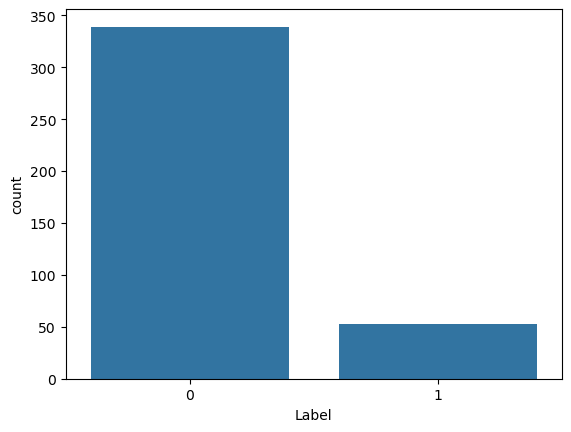

In [6]:
# countplot of sweeteners and non-sweeteners 
print(df['Label'].value_counts())
sns.countplot(data=df, x='Label')

We have data for about 400 ingredients. To create my synthetic dataset containing - Ingredient List and the name of the sweeteners in that list, I will create a custom function. 

In [5]:
import random

# a function to generate synthetic ingredient lists from existing ingredients
def create_ingredient_list(df, num_lists, min_ing, max_ing):
    ing_lst = []
    for _ in range(num_lists):
        # Randomly sampling ingredients
        list_length = random.randint(min_ing, max_ing)
        entry_ing_lst = df['Ingredient'].sample(list_length).tolist()
        single_list = ", ".join(entry_ing_lst)
        
        # Check for sweeteners
        sweeteners = []
        for ing in entry_ing_lst: 
            if df.loc[df['Ingredient'] == ing]['Label'].values[0] == 1: 
                sweeteners.append(ing) 
        
        sweeteners_result = ", ".join(sweeteners) if sweeteners else "nil"
        
        ing_lst.append({"Ingredient List": single_list, "Sweeteners?": sweeteners_result})
    
    return pd.DataFrame(ing_lst)


In [51]:
# I will create about 1000 different combinations with number of ingredients ranging between 3 and 7.
ingredient_list_df = create_ingredient_list(df, num_lists=1000, min_ing=3, max_ing=7)

# Display the first few rows
ingredient_list_df.head()

,Ingredient List,Sweeteners?
0,"EMULSIFIERS [481(i), 471 & 472e], RAISING AGEN...",nil
1,"Thiamine hydrochloride, calcium lactate, calci...",nil
2,"Edible Vegetable Oil (Soyabean, Palmolein), ir...",nil
3,"PRESERVATIVE (211), Milk solids, BHA, Maple su...",Maple sugar
4,"disodium guanylate or inosinate, Refined Soyab...",Xylitol


#### Great! Now our working dataset is ready! 
1. I need to preprocess the ingredient list such that all text is normalised (in lower case) and all extra terms in brackets are removed. This will assist us when we're working with any unseen ingredient list.
2. X = Vectorise the ingredient list using TF-IDF (since I'm working with a small dataset (500 entries)).
3. y = 1/0 label to indicate if any sweetener is detected or not. I may also report the probability for each ingredient to be detected as a sweetener for more informative output.
4. Perform the classification task for detecting sweeteners in the ingredient list.
5. Evaluate, analyse, tune hyperparameters.
6. Repeat 4-5 until satisfied. 

In [52]:
# save this dataset first, so that we can use it for all our tasks later
# maintains uniformity and ensures the same dataset is being used. 

ingredient_list_df.to_csv("ingredients_sweeteners_list.csv", index=False)

### 2. Data preprocessing. 

In [2]:
df = pd.read_csv("ingredients_sweeteners_list.csv")
df.head()

,Ingredient List,Sweeteners?
0,"EMULSIFIERS [481(i), 471 & 472e], RAISING AGEN...",nil
1,"Thiamine hydrochloride, calcium lactate, calci...",nil
2,"Edible Vegetable Oil (Soyabean, Palmolein), ir...",nil
3,"PRESERVATIVE (211), Milk solids, BHA, Maple su...",Maple sugar
4,"disodium guanylate or inosinate, Refined Soyab...",Xylitol


In [5]:
#!pip install spacy

In [24]:
#!python -m spacy download en_core_web_sm

In [1]:
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocessing function to
# Remove noise (e.g., text in brackets, special characters)
# Normalize case and remove leading/trailing spaces
def preprocess_text(text):

    # the ingredient list may involve text in the form "abc (def (ghi))" or abc [d (e) f]
    # main idea is i wish to remove all kinds text in brackets or any full stop
    pattern = r'\([^()]*\)|\[[^\[\]]*\]|[.]'
    
    # Continue removing brackets until no nested brackets remain
    while re.search(pattern, text):
        text = re.sub(pattern, '', text)
    
    text = text.lower().strip()  
    doc = nlp(text)
    # Lemmatize and remove stop words as well
    return " ".join([token.lemma_ for token in doc if not token.is_stop])


In [5]:
# Apply preprocessing to the 'Ingredient List' column
df['Preprocessed'] = df['Ingredient List'].apply(preprocess_text)

df.head()

,Ingredient List,Sweeteners?,Preprocessed
0,"EMULSIFIERS [481(i), 471 & 472e], RAISING AGEN...",nil,"emulsifier , raise agent , palmolein , double ..."
1,"Thiamine hydrochloride, calcium lactate, calci...",nil,"thiamine hydrochloride , calcium lactate , cal..."
2,"Edible Vegetable Oil (Soyabean, Palmolein), ir...",nil,"edible vegetable oil , iron ammonium citrate ,..."
3,"PRESERVATIVE (211), Milk solids, BHA, Maple su...",Maple sugar,"preservative , milk solid , bha , maple sugar ..."
4,"disodium guanylate or inosinate, Refined Soyab...",Xylitol,"disodium guanylate inosinate , refined soyabea..."


#### The dataset is now preprocessed properly and is ready for machine learning classification.

* X = vectorized form of the strings containing the ingredient list in 'Preprocessed' column.
* y = 1/0 based on whether the list consits of any sweeteners or not.
* This will allow the model to identify the patterns (of potential sweeteners) present in a list of ingredients form (which will be the input when a new unseen data is fed to the model).
* Afterwards, when dealing with unseen data, the list of ingredients will be tokenised and each token will be vectorized and the model will predict the possibility of the token being a sweetener or not. I will also present the prrobability of the prediction. 

In [6]:
df['Sweetener Label'] = df['Sweeteners?'].apply(lambda x: 0 if x=='nil' else 1)
df.head()

,Ingredient List,Sweeteners?,Preprocessed,Sweetener Label
0,"EMULSIFIERS [481(i), 471 & 472e], RAISING AGEN...",nil,"emulsifier , raise agent , palmolein , double ...",0
1,"Thiamine hydrochloride, calcium lactate, calci...",nil,"thiamine hydrochloride , calcium lactate , cal...",0
2,"Edible Vegetable Oil (Soyabean, Palmolein), ir...",nil,"edible vegetable oil , iron ammonium citrate ,...",0
3,"PRESERVATIVE (211), Milk solids, BHA, Maple su...",Maple sugar,"preservative , milk solid , bha , maple sugar ...",1
4,"disodium guanylate or inosinate, Refined Soyab...",Xylitol,"disodium guanylate inosinate , refined soyabea...",1


<Axes: xlabel='Sweetener Label', ylabel='count'>

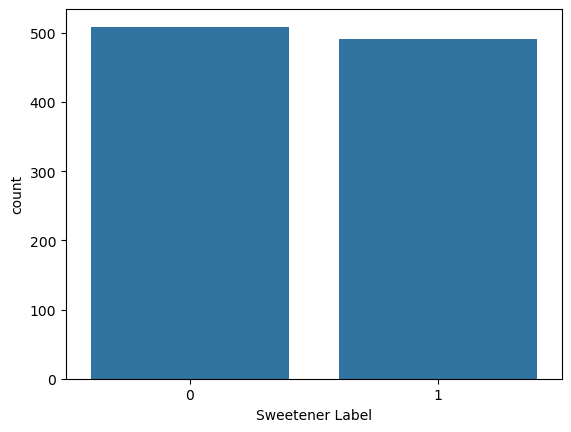

In [15]:
sns.countplot(data=df,x='Sweetener Label')

Okay, our dataframe is balanced. 

In [59]:
#!pip install --upgrade numpy scipy scikit-learn

In [7]:
# defining X and y 
X = df['Preprocessed']

# The target variable (1 if sweeteners present, 0 otherwise)
y = df['Sweetener Label']

In [8]:
from sklearn.model_selection import train_test_split

# Train-test split - 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_val, X_hold, y_val, y_hold = train_test_split(X_test, y_test, test_size=0.5, random_state=101)


In [9]:
# combining the train+validation sets if i need to perform randomisedsearchCV for tuning hyperparameters 

X_prac = pd.concat([X_train, X_val], axis=0) 
y_prac = pd.concat([y_train,y_val], axis=0) 

X_train.shape, X_val.shape, X_prac.shape

((800,), (100,), (900,))

In [10]:
# Train the base Random Forest model with default hyperparameters 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
vectorizer = TfidfVectorizer()

np.random.seed(101)
model = RandomForestClassifier()

# setting up a pipeline 
pipe = Pipeline([("vectorizer", vectorizer), ("model", model)])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

In [11]:
pipe.score(X_val,y_val)

0.95

In [26]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay 

# Evaluate the model
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        57
           1       1.00      0.88      0.94        43

    accuracy                           0.95       100
   macro avg       0.96      0.94      0.95       100
weighted avg       0.95      0.95      0.95       100



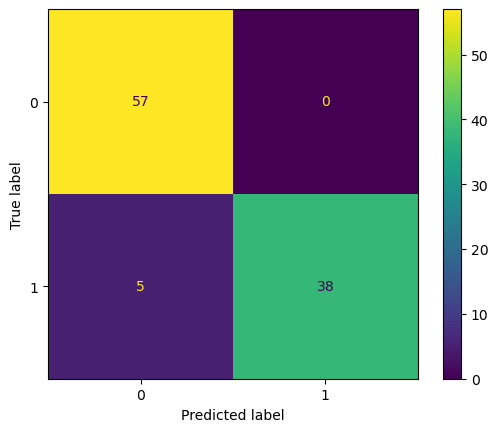

In [27]:
# the confusion matrix 
ConfusionMatrixDisplay.from_estimator(pipe,X_val,y_val)

Wow! The base model sure has performed extremely well. 
* If there are no sweeteners, then the model predicts that perfectly.
* If there are any sweeteners, the performance of the model is slighlty poor. 

In [29]:
# performing a randomized search CV before we try to adjust our model's predictions as the desired output 
from sklearn.model_selection import RandomizedSearchCV

# Train the base Random Forest model with default hyperparameters 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# TF-IDF vectorization
vectorizer = TfidfVectorizer()

np.random.seed(101)
model = RandomForestClassifier()

param_grid = {"n_estimators":np.arange(1,1000,50),
                 "max_depth":[None,3,5,7,10],
                 "min_samples_split":np.arange(2,20,2),
                 "min_samples_leaf":np.arange(1,20,2)}


RS = RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, verbose=True) 

# setting up a pipeline 
pipe = Pipeline([("vectorizer", vectorizer), ("model", RS)])

pipe.fit(X_prac,y_prac) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                                    n_iter=50,
                                    param_distributions={'max_depth': [None, 3,
                                                                       5, 7,
                                                                       10],
                                                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                                         'n_estimators': array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601,
       651, 701, 751, 801, 851, 901, 951])},
                                    verbose=True))])

In [32]:
RS.best_params_

{'n_estimators': np.int64(451),
 'min_samples_split': np.int64(6),
 'min_samples_leaf': np.int64(1),
 'max_depth': None}

In [12]:
# let's instantiate this tuned model and train it  

np.random.seed(101)
tuned_RF = RandomForestClassifier(n_estimators=451,
                                 min_samples_split=6,
                                 min_samples_leaf=1,
                                 max_depth=None)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()

# setting up a pipeline 
tuned_pipe = Pipeline([("vectorizer", vectorizer), ("model", tuned_RF)])

tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 RandomForestClassifier(min_samples_split=6,
                                        n_estimators=451))])

In [41]:
# Evaluate the model
y_pred = tuned_pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        57
           1       1.00      0.91      0.95        43

    accuracy                           0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100



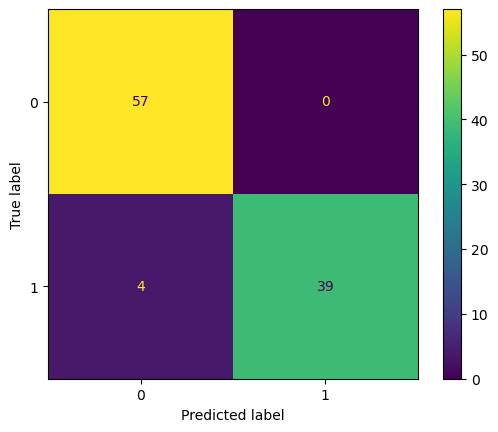

In [42]:
# the confusion matrix 
ConfusionMatrixDisplay.from_estimator(tuned_pipe,X_val,y_val)

### 4. Prediction on the hold-out test set.

In [49]:
# checking the score of our hold-out test set 
from sklearn.metrics import classification_report, ConfusionMatrixDisplay 

# Evaluate the model
yhold_pred = tuned_pipe.predict(X_hold)
print(classification_report(y_hold, yhold_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        48
           1       0.98      0.96      0.97        52

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



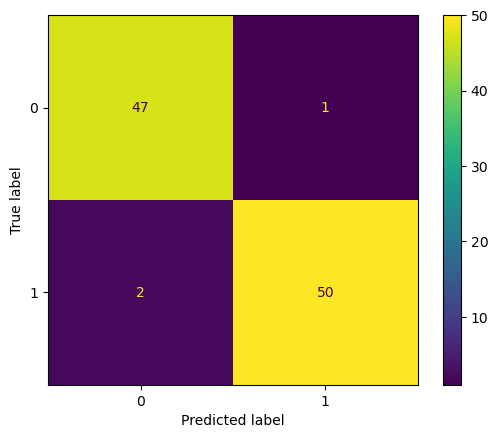

In [50]:
# the confusion matrix for the hold-out set 
ConfusionMatrixDisplay.from_estimator(tuned_pipe,X_hold,y_hold)

Okay, the model scores have certainly improved! Remember, this model only predicts if any sweetener is present in the ingredient list or not (a classification on the entire list!). It is not identifying the exact sweetener yet and the model has probably learned the patterns for any ingredient that classifies as a sweetener. 

To modify our outputs in the way we desire, we will need to tokenize our ingredient list before predicting its possibility of being a sweetener. 

In [101]:
# generating a function to analyse the ingredient list using 'tuned_pipe' model 

def sweet_truth_analyser(lst, model):    
    '''
    This function generates a dataframe presenting each ingredient separately, 
    our model's prediction whether its a sweetener or not and how confident our model is 
    on the prediction. 
    '''

    tokens = lst.split(", ")
    
    result = []
    
    for _, txt in enumerate(tokens): 
    
        prediction = 'Non-sweetener' if model.predict([txt])[0] == 0 else 'Sweetener'
        prob = max(tuned_pipe.predict_proba([txt])[0])*100
        
        result.append({'Ingredient': txt, 'Prediction': prediction, 'Confidence': prob})
    
    return pd.DataFrame(result)

In [103]:
# generating a function that produces only the sweeteners detected by our model, 
# from the ingredient list provided 

def sweet_truth_analyser_only_sweeteners(lst, model):    
    ''' 
    This function returns all the sweeteners detected by our model 
    from the list of ingredients provided as input.
    '''

    df = sweet_truth_analyser(lst, model)
    
    df2 = df_result[df_result['Prediction']=='Sweetener']
    df2 = df2.reset_index().drop(['index', 'Prediction'], axis=1) 

    if len(df2)!=0: 
        return pd.DataFrame(df2)
    else: 
        return "No sweeteners detected."

Testing our functions a random entry in the X_hold dataset. 

In [91]:
import random

In [102]:
idx = random.randint(0, len(X_hold)-1)
print("Random index selected:", idx, "\n")
print("List of ingredients corresponding to this index", X_hold.iloc[idx])
print("Target label - whether sweetener present (1) or not (0)?:", y_hold.iloc[idx], "\n")
print("The corresponding data in our originally curated synthetic dataframe:")
print(df[['Preprocessed', 'Sweeteners?']].iloc[X_hold.index[idx]], "\n")

sweet_truth_analyser(X_hold.iloc[idx], tuned_pipe)

Random index selected: 25 

List of ingredients corresponding to this index antioxidant , l - lysine , dextrose , milk solid
Target label - whether sweetener present (1) or not (0)?: 1 

The corresponding data in our originally curated synthetic dataframe:
Preprocessed    antioxidant , l - lysine , dextrose , milk solid
Sweeteners?                                             Dextrose
Name: 889, dtype: object 



,Ingredient,Prediction,Confidence
0,antioxidant,Non-sweetener,92.205396
1,l - lysine,Non-sweetener,84.099532
2,dextrose,Sweetener,68.181818
3,milk solid,Non-sweetener,71.423820


With our 2 functions that analyse each ingredient in a list ready, we can now create a pipeline for a prediction on unseen list. 

Steps needed to work on an unseen list: 
1) preprocess the list - normalise and remove all extra information in brackets, if any
2) pass it through the function `sweet_truth_analyser(list, model)` for the prediction.
3) Note: I will need to save the tuned model first.

Let this unseen data be from: 
* a randomly selected entry from our originally curated synthetic dataset - `ingredients_sweeteners_list.csv`.
* an actual ingredient list from any Indian food product.

### Some savings that I will need to do.  
1) Train the tuned model on entire X and then proceed to save it. 
2) Save my tuned model using joblib. 
3) Create a module with all my custom functions that will be required for the sweetener detection

In [107]:
# let's instantiate this tuned model again 
# train it on entire X (which has an already preprocessed list of text) and y
# dump this model using joblib 

import joblib 

np.random.seed(101)
tuned_RF = RandomForestClassifier(n_estimators=451,
                                 min_samples_split=6,
                                 min_samples_leaf=1,
                                 max_depth=None)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()

# setting up a pipeline 
tuned_pipe = Pipeline([("vectorizer", vectorizer), ("model", tuned_RF)])

# training the tuned model on entire X and y 
# since I am satisfied with the model's performance for now 
tuned_pipe.fit(X, y)

joblib.dump(tuned_pipe, 'sweet_truth_detector.pkl')

['sweet_truth_detector.pkl']